In [186]:
import cbpro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import ta
from datetime import datetime, timedelta
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

In [2]:
import json
with open("config.json") as json_data_file:
    config = json.load(json_data_file)
client = cbpro.AuthenticatedClient(config["api_public"], config["api_secret"], config["passphrase"])

## DATA RETRIEVAL AND CLEANING


In [170]:
def getminutedata(symbol, interval_min=1, lookback=24*60):
    '''
    Method to obtain minute data from the Coinbase Pro API
    
    Parameters
    ----------
    
    symbol : str
         Symbol of the currency, e.g., "BTC-EUR", "DOT-EUR", "BTC-USD", "DOT-USD"
    
    interval_min : int
            The interval in minutes between the retrieved timestamps, can only be in the following range [1, 5, 15, 60, 360, 1440]
    
    lookback : int
        The number of minutes to lookback starting from the current timestamp
        
    Returns
    -------
    Pandas Dataframe
        a dataframe with the trade data

    '''
    
    MAX_REQUESTS = 300  # can only request 300 timestamps each time
    interval_sec = interval_min*60  # interval in seconds
    
    end = pd.to_datetime(client.get_time()["epoch"], unit ="s")  # end date
    start = end - timedelta(minutes=lookback)  # start date
    current_start = start
    
    try:
        # one request can only retrieve up to 300 timestamps: use for loop to obtain the desired range with multiple requests
        dataframes = []
        n_timestamps = int(lookback/interval_min)
        delta = timedelta(minutes=min(lookback, MAX_REQUESTS)*interval_min)  # time between each timestamp
        for i in range(int(n_timestamps/MAX_REQUESTS)):    
            current_end = current_start + delta
            dataframes.append(pd.DataFrame(client.get_product_historic_rates(symbol, current_start.isoformat(), current_end.isoformat(), interval_sec))[::-1])
            current_start = current_end
        dataframes.append(pd.DataFrame(client.get_product_historic_rates(symbol, current_start.isoformat(), end, interval_sec))[::-1])
        df = pd.concat(dataframes)
    except:
        print("ERROR:")
        print(client.get_product_historic_rates(symbol, current_start.isoformat(), current_end.isoformat(), interval_sec))  # should print what error we got
        
    # clean dataframe
    df.columns = ["Time", "Low", "High", "Open", "Close", "Volume"]
    df = df.astype(float)
    df = df.set_index("Time")
    df.index = pd.to_datetime(df.index, unit ="s")
    
    # add some measures
    df['RSI'] = ta.momentum.rsi(df.Close, window=10)
    df['SMA200'] = ta.trend.sma_indicator(df.Close, window=200)
    df['EMA200'] = ta.trend.ema_indicator(df.Close, window=200)
    df['SMA100'] = ta.trend.sma_indicator(df.Close, window=100)
    df['EMA100'] = ta.trend.ema_indicator(df.Close, window=100)
    df['SMA50'] = ta.trend.sma_indicator(df.Close, window=50)
    df['EMA50'] = ta.trend.ema_indicator(df.Close, window=50)
    df['SMA60'] = ta.trend.sma_indicator(df.Close, window=60)
    df['EMA60'] = ta.trend.ema_indicator(df.Close, window=60)

    df["pct change"] =df.Open.pct_change()+1
    df["CUM_RETURNS_50"] = (df.Open.pct_change()+1).rolling(50).apply(np.prod)
    df["CUM_RETURNS_60"] = (df.Open.pct_change()+1).rolling(60).apply(np.prod)
    df["CUM_RETURNS_100"] = (df.Open.pct_change()+1).rolling(100).apply(np.prod)

    return df

    
    

## Strategies

The function for each strategy should be able to take a **pandas dataframe** as input and returns **"BUY", "SELL", "NO TRADE"** to indicate whether and what kind of trade will happen.

In [254]:
def RSI_SMA_return_strategy(row, entried = False, max_profit=1.010, stop_loss=0.985):
    signal = (row.Close > row.SMA60) & (row.RSI < 40) & (row.CUM_RETURNS_60 < 1.03)  # RSI SMA strategy
    
    # not entried yet so try to buy
    if not entried:
        if signal:
            return "BUY" # buy next open
        
    # entried into a buy position so try to sell at a good price
    if entried:
        price_change_since_buying = row.Open/row.last_buying_price
        if row.RSI > 60:
            return "SELL" # sell next open
        elif price_change_since_buying > max_profit or price_change_since_buying < stop_loss:
            return "SELL"

    return "NO TRADE"  # No trade



In [248]:
def RSI_SMA_strategy(row, entried = False, stop_loss=0.985):
    signal = (row.Close > row.EMA50) & (row.RSI < 40)  # RSI SMA strategy
    
    # not entried yet so try to buy
    if not entried:
        if signal:
            return "BUY" # buy next open
        
    # entried into a buy position so try to sell at a good price
    if entried:
        price_change_since_buying = row.Open/row.last_buying_price
        if row.RSI > 50:
            return "SELL" # sell next open

        elif price_change_since_buying < stop_loss:
            return "SELL"

    return "NO TRADE"  # No trade

    

## Backtesting

In [258]:
def backtest(strategy, df):
    '''
    Backtest your strategy with this function
    
    Parameters
    ----------
    
    strategy : func
        function that returns "BUY", "SELL", "NO TRADE"
        
    df : pandas dataframe
        dataframe containing the trading data
    
    Returns
    -------
    Pandas dataframe
        dataframe containing the buying/selling dates with the profits, returns and open prices
    
    '''
    
    buying_dates = []
    buying_open_prices = []
    selling_dates = []
    selling_open_prices = []
    entried = False
    
    # check per row whether we want to buy or sell the stock
    for i in range(len(df)-1):
        row = df.iloc[i].copy()
        next_row = df.iloc[i+1].copy()
        if entried:
            row["last_buying_price"] = buying_open_prices[-1]
        
        action = strategy(row, entried)
        timestamp = next_row.name
        
        if action == "BUY":
            entried = True
            buying_dates.append(timestamp)
            buying_open_prices.append(next_row.Open)
        elif action == "SELL":
            entried = False
            selling_dates.append(timestamp)
            selling_open_prices.append(next_row.Open)
    
    # if we have more buying dates, then it means that the last selling date has not taken place yet
    if len(buying_dates) > len(selling_dates):
        buying_dates = buying_dates[:-1]
        buying_open_prices = buying_open_prices[:-1]
        
    actual_trades = pd.DataFrame({"buying_date": buying_dates, "selling_date": selling_dates, "buying_open_price": buying_open_prices, "selling_open_price": selling_open_prices})
    
    
        
    # plot results
    plt.style.use("ggplot")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    ax=axes[0,0]
    ax2=axes[1,0]
    ax3 = axes[0,1]
    
    #ax1
    df.plot(kind="line", y="Open", ax=ax, linewidth=0.7, alpha =0.5)
    #df.plot(kind="line", y="SMA200", c="orange", alpha =1, ax=ax, label = "SMA200")
    #df.plot(kind="line", y="EMA200", c="purple", alpha =1, ax=ax, label = "EMA200")
    #df.plot(kind="line", y="SMA50", alpha =1, ax=ax, label = "SMA50")
    #df.plot(kind="line", y="EMA100", alpha =1, ax=ax, label = "EMA100")
    #df.plot(kind="line", y="SMA100", alpha =1, ax=ax, label = "SMA100")
    #df.plot(kind="line", y="EMA50", alpha =1, ax=ax, label = "EMA50")
    
    df.plot(kind="line", y="SMA60", alpha =0.5, ax=ax, label = "SMA60")
    df.plot(kind="line", y="EMA60", c ="purple", alpha =0.5, ax=ax, label = "EMA60")
    actual_trades.plot(kind="scatter", s=20, c="red", x="buying_date", y="buying_open_price", ax=ax, label="BUY", alpha=1)
    actual_trades.plot(kind="scatter", s=20, c="green", x="selling_date", y="selling_open_price", ax=ax, label="SELL", alpha=1)
    ax.set_xlabel("time")
    ax.set_ylabel("price")
    #ax2
    df.plot(kind="line", y="RSI", linewidth=0.5, alpha =1, ax=ax2, label = "RSI")
    ax2.set_ylim((0,100))
    ax2.axhline(50, c="black")
    ax2.axhline(30, c="black")
    ax2.set_xlabel("time")
    #ax3
    df.plot(kind="line", y="pct change", c="orange", linewidth=0.7, alpha =1, ax=ax3, label = "pct change")
    #df.plot(kind="line", y="CUM_RETURNS_50", c="purple", linewidth=1, alpha = 0.7, ax=ax3, label = "CUM_RETURNS_50")
    df.plot(kind="line", y="CUM_RETURNS_60", c="green", linewidth=1, alpha = 0.7, ax=ax3, label = "CUM_RETURNS_60")
    ax3.set_xlabel("time")


    #myFmt = mdates.DateFormatter(' %H:%M:')

    #ax.xaxis.set_major_formatter(myFmt)



    plt.gcf().autofmt_xdate()
    
    # if there are actual trades retrieve the performance measures
    if len(actual_trades) > 0:
        # performance measures
        profits = df.loc[actual_trades.selling_date].Open.values - df.loc[actual_trades.buying_date].Open.values
        winning_rate = np.sum([profits>0])/len(profits)
        returns = (df.loc[actual_trades.selling_date].Open.values - df.loc[actual_trades.buying_date].Open.values)/df.loc[actual_trades.buying_date].Open.values

        # adding performance measures to dataframe
        actual_trades["profit"] = profits
        actual_trades["return"] = returns

        # print results
        print("ACTUAL TRADES:")
        print(actual_trades)
        print("\n")
        print("profit: %.2f" % sum(profits)) 
        print("average returns:  %.6f" % (sum(returns)/max(1, len(returns))))
        print("returns:  %.6f" % (np.prod(returns)/max(1, len(returns))))
        print("winning rate:  %.2f" % (winning_rate))
        return actual_trades
    else:

        print("NO TRADES HAVE TAKEN PLACE")
        return None

ACTUAL TRADES:
           buying_date        selling_date  buying_open_price  selling_open_price  profit    return
0  2021-12-06 22:35:00 2021-12-06 22:39:00           44733.19            44822.61   89.42  0.001999
1  2021-12-06 23:11:00 2021-12-06 23:37:00           45035.07            44838.07 -197.00 -0.004374
2  2021-12-07 03:44:00 2021-12-07 03:50:00           45085.35            45110.39   25.04  0.000555
3  2021-12-07 04:35:00 2021-12-07 04:56:00           45286.14            45186.59  -99.55 -0.002198
4  2021-12-07 09:41:00 2021-12-07 10:01:00           45606.09            45583.12  -22.97 -0.000504
5  2021-12-07 15:26:00 2021-12-07 15:34:00           45880.93            45913.79   32.86  0.000716
6  2021-12-08 05:49:00 2021-12-08 05:59:00           44668.62            44705.18   36.56  0.000818
7  2021-12-08 06:38:00 2021-12-08 06:43:00           44829.91            44850.58   20.67  0.000461
8  2021-12-08 15:30:00 2021-12-08 15:59:00           44893.55            44764.18 -12

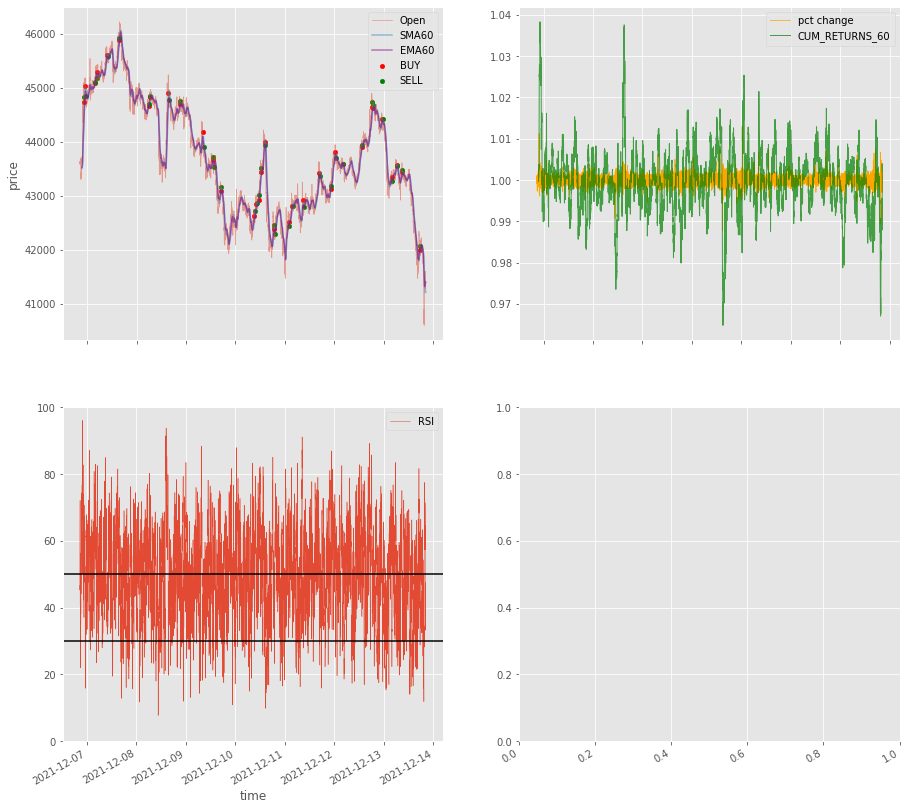

In [259]:
df = getminutedata("BTC-EUR", interval_min=1, lookback=60*24*7)
results = backtest(RSI_SMA_strategy, df)

ACTUAL TRADES:
           buying_date        selling_date  buying_open_price  selling_open_price  profit    return
0  2021-12-06 22:35:00 2021-12-06 22:40:00           44733.19            44929.18  195.99  0.004381
1  2021-12-06 23:11:00 2021-12-06 23:55:00           45035.07            44811.10 -223.97 -0.004973
2  2021-12-07 01:03:00 2021-12-07 01:06:00           44945.97            45025.97   80.00  0.001780
3  2021-12-07 02:40:00 2021-12-07 02:56:00           44982.02            45042.65   60.63  0.001348
4  2021-12-07 03:44:00 2021-12-07 03:52:00           45085.35            45142.90   57.55  0.001276
..                 ...                 ...                ...                 ...     ...       ...
56 2021-12-13 06:22:00 2021-12-13 08:11:00           43566.32            43483.50  -82.82 -0.001901
57 2021-12-13 09:04:00 2021-12-13 09:49:00           43445.57            43406.19  -39.38 -0.000906
58 2021-12-13 11:51:00 2021-12-13 11:57:00           43320.10            43394.83   7

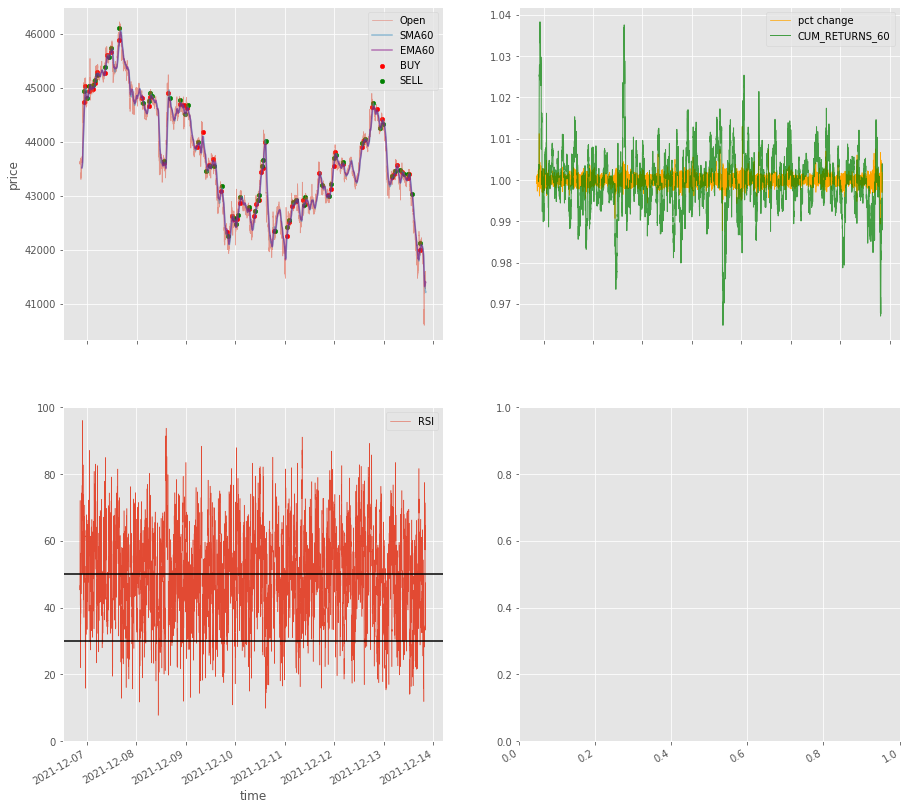

In [260]:
df = getminutedata("BTC-EUR", interval_min=1, lookback=60*24*7)
results = backtest(RSI_SMA_return_strategy, df)

## TRADING BOT

In [15]:
# simple strategy
def strategytest(symbol, qty=0, entried=False):
    while not entried:
        df = getminutedata(symbol)
        cumulret = (df.Open.pct_change()+1).cumprod() - 1
        if not entried:
            if cumulret[-1] < - 0.001:
                #  order = client.create_order(symbol=symbol, side ="BUY", type="MARKET", quantity=qty)
                #  print(order)
                print("BUY at %.3f" % df.Open[-1])
                transactTime = df.index[-1]
                entried=True
            else:
                print("no trade")
    if entried:
        while True:
            df = getminutedata(symbol)
            # sincebuy = df.loc[df.index>pd.to_datetime(order["transactTime"], unit="ms")]
            sincebuy = df.loc[df.index > transactTime]
            if len(sincebuy > 0):
                sincebuyret = (sincebuy.Open.pct_change() + 1).cumprod() - 1
                if sincebuyret[-1] > 0.0015 or sincebuyret[-1] < -0.0015:
                    #order = client.create_order(symbol=symbol, side ="SELL", type="MARKET", quantity=qty)
                    #print(order)
                    print("SELL at %.3f" % df.Open[-1])
                    break
                    
                

In [19]:
def test(x):
    return 1 + x

def test2(func, x):
    print(func(x))
    
test2(test, 10)
    

11


In [21]:
a = [1,2,3,4]
a=a[:-1]

In [22]:
a

[1, 2, 3]

In [90]:
a = df.iloc[1]

In [92]:
a["test"] = 1

In [187]:
df

,Low,High,Open,Close,Volume,RSI,SMA200,EMA200,SMA100,EMA100,SMA50,EMA50,SMA60,EMA60,pct change,CUM_RETURNS_50,CUM_RETURNS_60,CUM_RETURNS_100
Time,,,,,,,,,,,,,,,,,,
2021-11-13 17:03:00,56632.32,56669.74,56642.44,56645.13,0.090388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-13 17:04:00,56626.02,56656.76,56654.04,56636.98,0.620823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000205,NaN,NaN,NaN
2021-11-13 17:05:00,56632.08,56660.14,56651.46,56648.03,0.686487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999954,NaN,NaN,NaN
2021-11-13 17:06:00,56632.74,56654.29,56639.81,56639.76,0.257913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999794,NaN,NaN,NaN
2021-11-13 17:07:00,56599.18,56653.75,56653.75,56601.99,0.170951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000246,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13 16:58:00,41570.26,41703.81,41620.00,41680.47,1.555310,41.831459,42253.59405,42204.051538,41907.0855,41931.829714,41776.4064,41798.550752,41809.449167,41821.966332,0.999024,0.987486,0.996223,0.985800
2021-12-13 16:59:00,41679.89,41818.23,41706.55,41769.32,0.571288,51.593953,42247.90950,42199.725851,41903.1107,41928.611700,41770.3444,41797.404448,41806.725833,41820.240223,1.002080,0.990208,0.996601,0.987904
2021-12-13 17:00:00,41700.02,41814.69,41768.48,41798.17,1.414351,54.357626,42242.06500,42195.730271,41898.7704,41926.028696,41766.8336,41797.434469,41804.320333,41819.516609,1.001485,0.993004,0.996311,0.990244
